In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Input, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [3]:
# Load the dataset (replace 'Dataset.csv' with your actual dataset path)
data1 = pd.read_csv('Dataset.csv')
Q1 = data1['Target'].quantile(0.25)
Q3 = data1['Target'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

    # Filter the data to remove outliers
data = data1[(data1['Target'] >= lower_bound) & (data1['Target'] <= upper_bound)]

# Separate features and target (assume 'Target' is the target column)
target_column = 'Target'
features = data.drop(target_column, axis=1)
target = data[target_column]

# Normalize features and target using MinMaxScaler
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

# Split data into training and test sets
train_size = int(len(features_scaled) * 0.8)
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = target_scaled[:train_size], target_scaled[train_size:]


In [4]:
# Define the Autoencoder model
def build_autoencoder(input_shape, latent_dim=64):
    # Encoder
    inputs = Input(shape=input_shape)
    encoded = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(inputs)
    encoded = Bidirectional(LSTM(64, activation='relu'))(encoded)
    latent = Dense(latent_dim, activation='relu')(encoded)

    # Decoder
    decoded = RepeatVector(input_shape[0])(latent)
    decoded = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(decoded)
    decoded = Bidirectional(LSTM(128, activation='relu', return_sequences=True))(decoded)
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)

    # Compile the Autoencoder
    autoencoder = Model(inputs, outputs)
    encoder = Model(inputs, latent)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

# Build and train the autoencoder
input_shape = (1, X_train.shape[1])  # Using 1 timestep
autoencoder, encoder = build_autoencoder(input_shape)

autoencoder.fit(X_train.reshape(-1, 1, X_train.shape[1]), 
                X_train.reshape(-1, 1, X_train.shape[1]), 
                epochs=50, batch_size=32, validation_split=0.2, 
                callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


Epoch 1/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.0191 - val_loss: 0.0035
Epoch 2/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 3/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 9.4214e-04 - val_loss: 0.0014
Epoch 4/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 7.0976e-04 - val_loss: 0.0011
Epoch 5/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 5.4926e-04 - val_loss: 0.0010
Epoch 6/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 4.5626e-04 - val_loss: 7.5900e-04
Epoch 7/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3.7133e-04 - val_loss: 6.6357e-04
Epoch 8/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 3.1624e-04 - val_loss: 5.7992e-04
Epoch 9/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 2.6016e-04 - val_loss: 5.9403e-04
Epoch 10/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 2.3609e-04 - val_loss: 5.0539e-04
Epoch 11/50
1267/1267 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms

In [5]:
# Create sequences using rolling windows
def create_sequences(data, target, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Generate sequences for training and test data
window_size = 24  # Rolling window size of 24 hours
X_train_seq, y_train_seq = create_sequences(encoder.predict(X_train.reshape(-1, 1, X_train.shape[1])), y_train, window_size)
X_test_seq, y_test_seq = create_sequences(encoder.predict(X_test.reshape(-1, 1, X_test.shape[1])), y_test, window_size)

print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}, y_test_seq shape: {y_test_seq.shape}")


1583/1583 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
396/396 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
X_train_seq shape: (50625, 24, 64), y_train_seq shape: (50625, 1)
X_test_seq shape: (12639, 24, 64), y_test_seq shape: (12639, 1)


In [ ]:
# Define the BiLSTM model
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression

    model.compile(optimizer='adam', loss='mse')
    return model

# Build and train the BiLSTM model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
bilstm_model = build_bilstm_model(input_shape)

bilstm_model.fit(X_train_seq, y_train_seq, 
                 epochs=50, batch_size=32, validation_split=0.2, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])


C:\Users\Danie\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - loss: 0.0161 - val_loss: 0.0148
Epoch 2/50
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 0.0115 - val_loss: 0.0154
Epoch 3/50
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - loss: 0.0109 - val_loss: 0.0175
Epoch 4/50
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - loss: 0.0106 - val_loss: 0.0165
Epoch 5/50
1265/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0103

438/438 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
MAE: 22.8910, RMSE: 88.5102


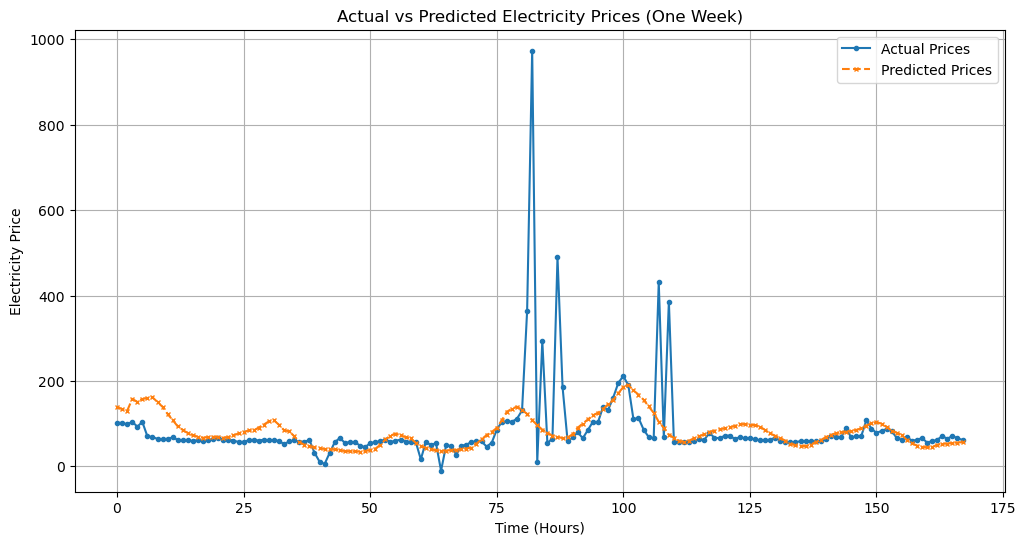

In [47]:
# Predict using the trained BiLSTM model
y_pred_seq = bilstm_model.predict(X_test_seq)

# Rescale predictions and actual values back to original scale
y_pred_rescaled = target_scaler.inverse_transform(y_pred_seq)
y_test_rescaled = target_scaler.inverse_transform(y_test_seq)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

# Plot actual vs predicted prices for one week (168 hours)
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:168], label='Actual Prices', marker='o', linestyle='-', markersize=3)
plt.plot(y_pred_rescaled[:168], label='Predicted Prices', marker='x', linestyle='--', markersize=3)

plt.title('Actual vs Predicted Electricity Prices (One Week)')
plt.xlabel('Time (Hours)')
plt.ylabel('Electricity Price')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [16]:
# Extract latent features from the encoder
train_latent_features = encoder.predict(X_train_reshaped)
test_latent_features = encoder.predict(X_test_reshaped)

print(f'Latent Feature Shape (Train): {train_latent_features.shape}')
print(f'Latent Feature Shape (Test): {test_latent_features.shape}')


74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Latent Feature Shape (Train): (2337, 64)
Latent Feature Shape (Test): (584, 64)


In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [23]:
# Generate latent features using the trained encoder from the autoencoder
train_latent_features = encoder.predict(X_train_reshaped)
test_latent_features = encoder.predict(X_test_reshaped)

# Ensure the latent features are reshaped for LSTM input: (samples, timesteps, features)
timesteps = 1  # For BiLSTM, we keep timesteps as 1 since we are treating each latent vector as a sequence step
train_latent_reshaped = train_latent_features.reshape(train_latent_features.shape[0], timesteps, -1)
test_latent_reshaped = test_latent_features.reshape(test_latent_features.shape[0], timesteps, -1)

# Define the BiLSTM model
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, activation='relu')))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression (predicting prices)
    
    model.compile(optimizer='adam', loss='mse')
    return model

# Define the input shape: (timesteps, latent_dim)
input_shape = (train_latent_reshaped.shape[1], train_latent_reshaped.shape[2])

# Build the BiLSTM model
bilstm_model = build_bilstm_model(input_shape)

# Train the BiLSTM model
history = bilstm_model.fit(
    train_latent_reshaped, y_train,  # y_train: actual prices
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


C:\Users\Danie\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.0189 - val_loss: 3.6277e-04
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.2714e-04 - val_loss: 2.7823e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3867e-04 - val_loss: 2.8964e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.8736e-04 - val_loss: 2.3244e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8849e-04 - val_loss: 2.3687e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.9747e-04 - val_loss: 2.1084e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.4682e-04 - val_loss: 2.0585e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.1828e-04 - val_loss: 2.0914e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6725e-04 - val_loss: 2.0732e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.6410e-04 - val_loss: 2.1592e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9179e-04 - val_loss:

In [27]:
# Ensure the number of samples in predictions matches the y_test
y_pred = bilstm_model.predict(test_latent_reshaped)

# Flatten the predictions to match y_test shape
y_pred = y_pred.flatten()

# Ensure y_test is also flattened
y_test_flat = y_test.flatten()

print(f"y_test length: {len(y_test_flat)}, y_pred length: {len(y_pred)}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
y_test length: 14026, y_pred length: 584


In [29]:
# Check for length mismatch and adjust if necessary
min_length = min(len(y_test_flat), len(y_pred))

# Trim both arrays to the same length
y_test_trimmed = y_test_flat[:min_length]
y_pred_trimmed = y_pred[:min_length]

print(f"Trimmed lengths - y_test: {len(y_test_trimmed)}, y_pred: {len(y_pred_trimmed)}")


Trimmed lengths - y_test: 584, y_pred: 584


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE and RMSE with trimmed arrays
mae = mean_absolute_error(y_test_trimmed, y_pred_trimmed)
rmse = np.sqrt(mean_squared_error(y_test_trimmed, y_pred_trimmed))

print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')


MAE: 0.0051, RMSE: 0.0140


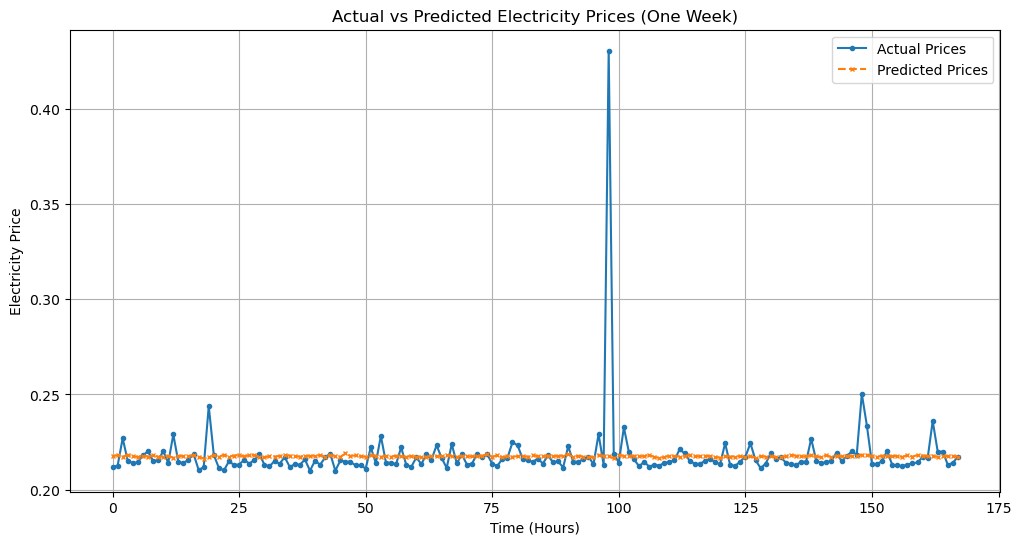

In [33]:
import matplotlib.pyplot as plt

# Define the number of data points for one week (assuming hourly data)
week_hours = 7 * 24  # 7 days * 24 hours = 168 points

# Ensure both arrays are trimmed to have at least 168 data points
min_length = min(len(y_test_trimmed), len(y_pred_trimmed), week_hours)

# Extract the first week of actual and predicted prices
y_test_week = y_test_trimmed[:min_length]
y_pred_week = y_pred_trimmed[:min_length]

# Plot the actual vs predicted prices for one week
plt.figure(figsize=(12, 6))
plt.plot(y_test_week, label='Actual Prices', marker='o', linestyle='-', markersize=3)
plt.plot(y_pred_week, label='Predicted Prices', marker='x', linestyle='--', markersize=3)

plt.title('Actual vs Predicted Electricity Prices (One Week)')
plt.xlabel('Time (Hours)')
plt.ylabel('Electricity Price')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


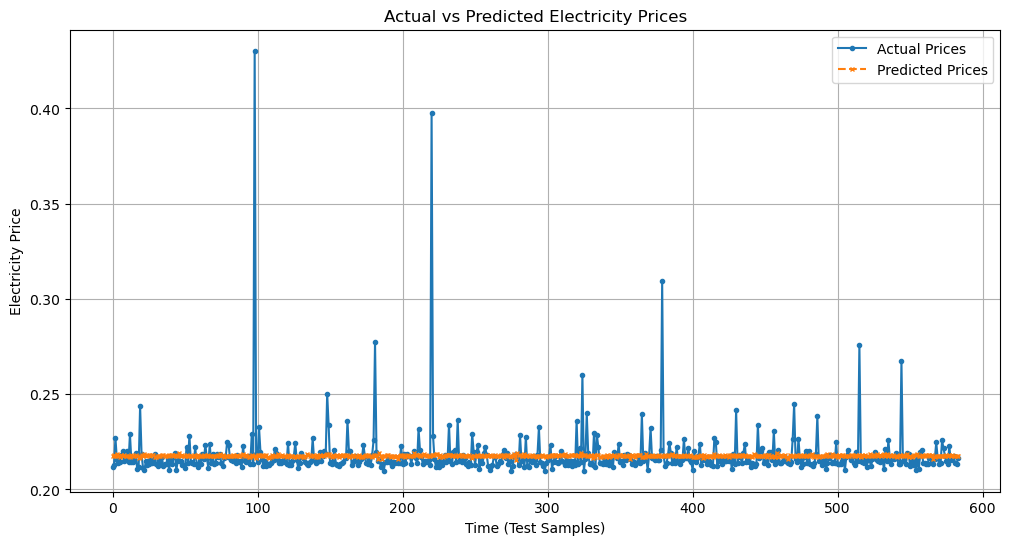

In [35]:
import matplotlib.pyplot as plt

# Ensure the predicted and actual arrays are trimmed to the same length
min_length = min(len(y_test_flat), len(y_pred))
y_test_trimmed = y_test_flat[:min_length]
y_pred_trimmed = y_pred[:min_length]

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_trimmed, label='Actual Prices', marker='o', linestyle='-', markersize=3)
plt.plot(y_pred_trimmed, label='Predicted Prices', marker='x', linestyle='--', markersize=3)

plt.title('Actual vs Predicted Electricity Prices')
plt.xlabel('Time (Test Samples)')
plt.ylabel('Electricity Price')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
